# 0. Download and Import Library

In [1]:
!pip install opencv-python pytesseract matplotlib

  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached pytesseract-0.3.10-py3-none-any.whl (14 kB)
  Using cached matplotlib-3.7.1-cp39-cp39-win_amd64.whl (7.6 MB)
  Using cached numpy-1.24.3-cp39-cp39-win_amd64.whl (14.9 MB)
  Using cached Pillow-9.5.0-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached contourpy-1.0.7-cp39-cp39-win_amd64.whl (160 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached kiwisolver-1.4.4-cp39-cp39-win_amd64.whl (55 kB)
  Using cached zipp-3.15.0-py3-none-any.whl (6.8 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)


In [9]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-2.0.1%2Bcu117-cp39-cp39-win_amd64.whl (2343.7 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.15.2%2Bcu117-cp39-cp39-win_amd64.whl (4.9 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-2.0.2%2Bcu117-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached https://download.pytorch.org/whl/networkx-3.0-py3-none-any.whl (2.0 MB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.9.0-py3-none-any.whl (9.7 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached https://download.pytorch.org/whl/numpy-1.24.1-cp39-cp39-win_amd64.whl (14.9 MB)
  Using cached https://download.pytorch.org/whl/requests-2.28.1

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

In [3]:
#Check if CUDA works in gpu
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060'

# 1. Header File for Pre Processing Image

## 1.1 Read Input Image

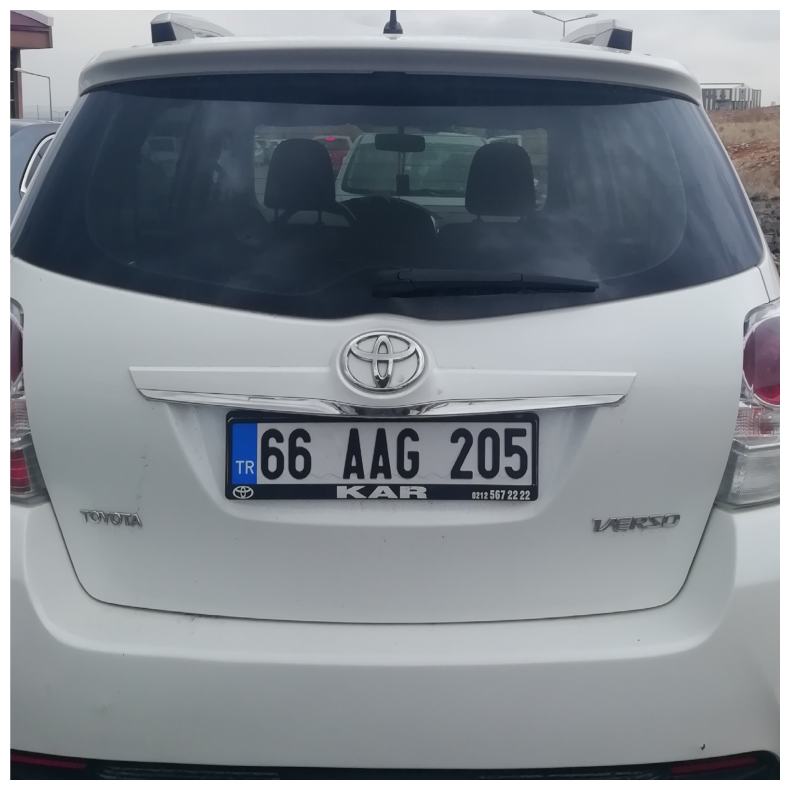

In [4]:
img_ori = cv2.imread(r'..\PlakaTanima\Plate_Car\642.jpg')
im_rgb = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(im_rgb, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car.png',bbox_inches = 'tight')
plt.show()

## 1.2 Convert Image to Grayscale

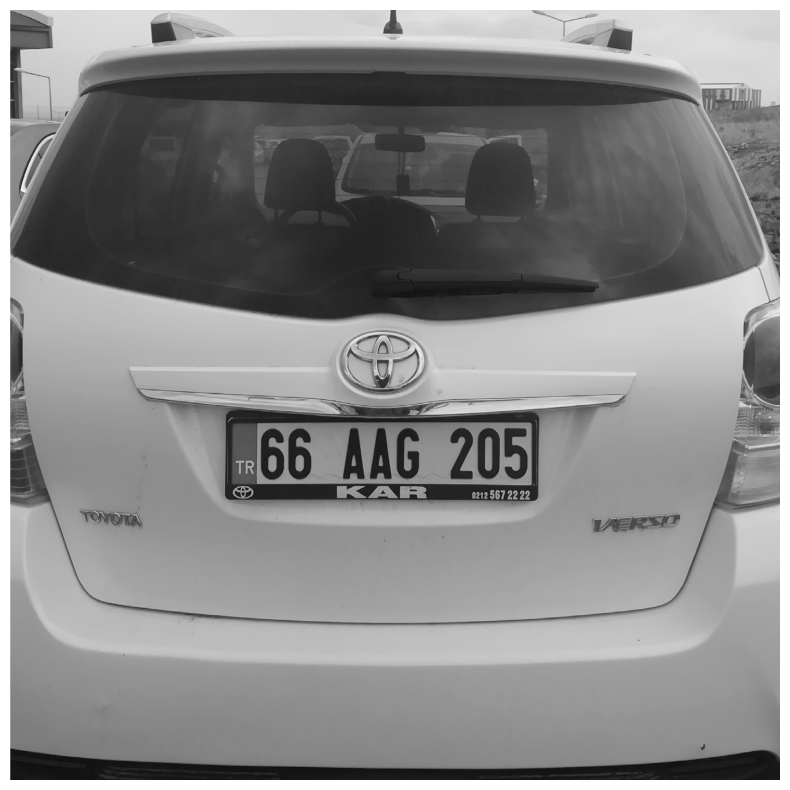

In [5]:
gray = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('Car-GrayScale.png',bbox_inches = 'tight')
plt.show()

## 1.3 Maximize Contrast

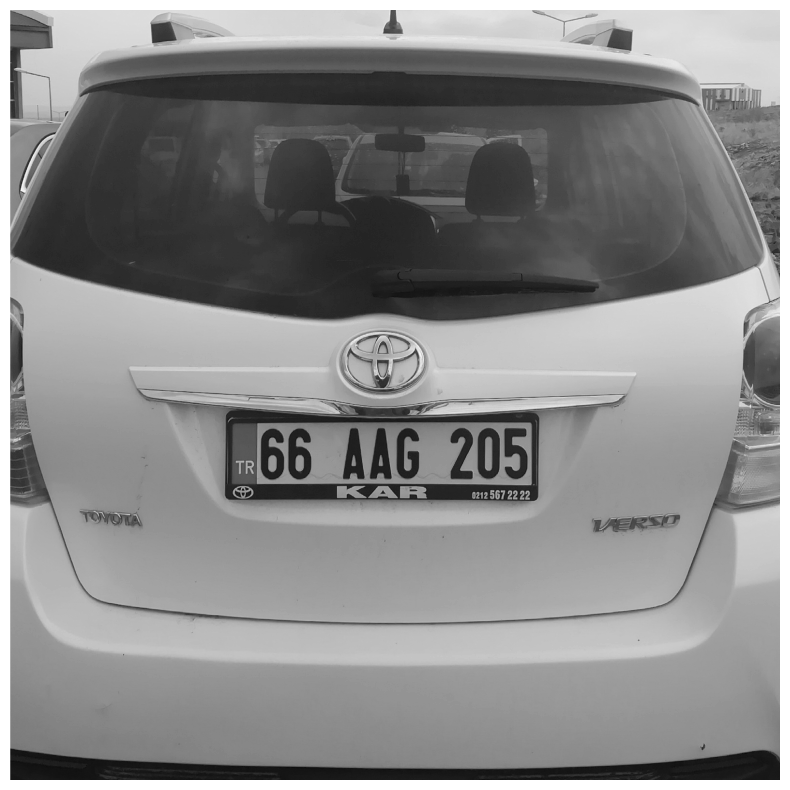

In [6]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

# Dilation Process, goal is reduce the pixel spacing

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car-Contrast.png',bbox_inches = 'tight')
plt.show()

## 1.4 Adaptive Thresholding

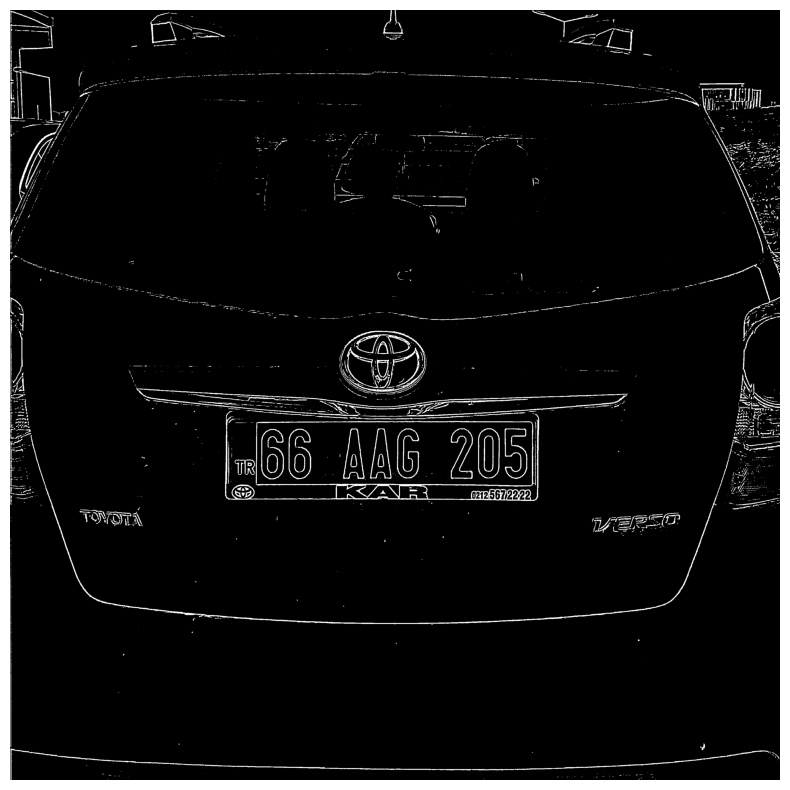

In [7]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

# Separate the image regions and highlighting the edges

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car-Adaptive-Thresholding.png',bbox_inches = 'tight')
plt.show()

## 1.5 Finding Contours to locate plate

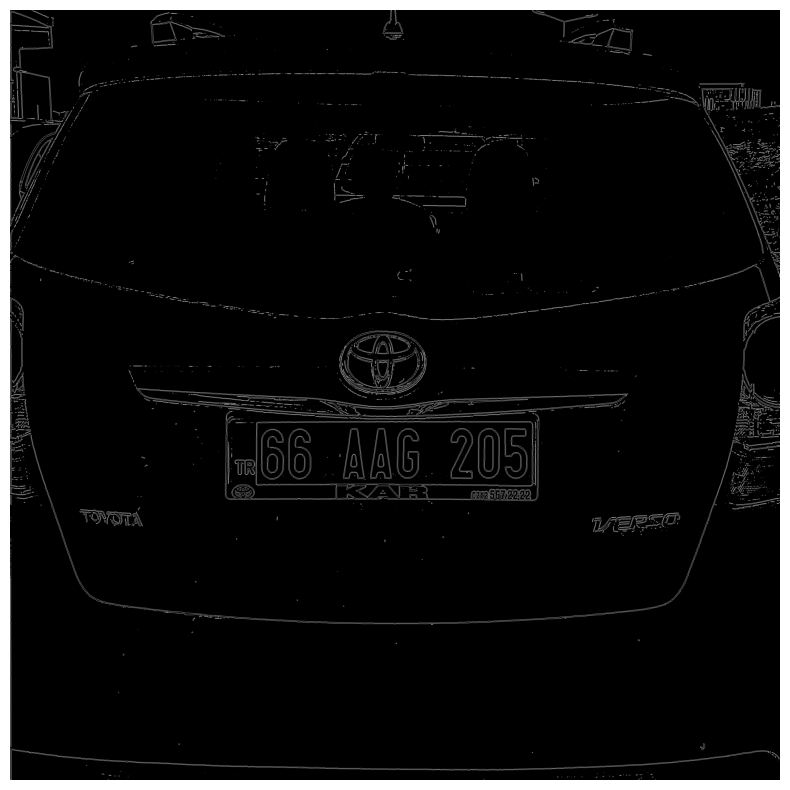

In [8]:
    contours, _= cv2.findContours(
        img_thresh, 
        mode=cv2.RETR_LIST, 
        method=cv2.CHAIN_APPROX_SIMPLE
    )

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)
plt.axis('off')
plt.savefig('CarPic\Car-Contours.png',bbox_inches = 'tight')
plt.show()

## 1.6 Data Preparation

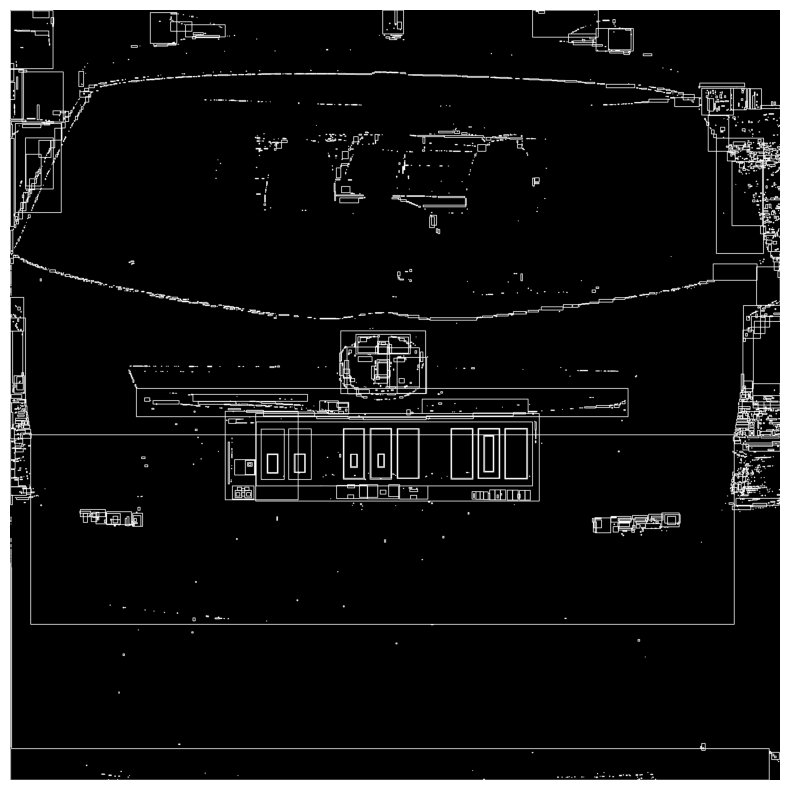

In [9]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

# A function used to create an approximate rectangle along with the image.

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car-Boxes.png',bbox_inches = 'tight')
plt.show()

In [10]:
contours_dict

[{'contour': array([[[2529, 3102]]], dtype=int32),
  'x': 2529,
  'y': 3102,
  'w': 1,
  'h': 1,
  'cx': 2529.5,
  'cy': 3102.5},
 {'contour': array([[[ 395, 3102]],
  
         [[ 396, 3103]],
  
         [[ 397, 3103]],
  
         [[ 396, 3102]]], dtype=int32),
  'x': 395,
  'y': 3102,
  'w': 3,
  'h': 2,
  'cx': 396.5,
  'cy': 3103.0},
 {'contour': array([[[ 433, 3101]]], dtype=int32),
  'x': 433,
  'y': 3101,
  'w': 1,
  'h': 1,
  'cx': 433.5,
  'cy': 3101.5},
 {'contour': array([[[2601, 3100]],
  
         [[2601, 3101]],
  
         [[2602, 3101]],
  
         [[2602, 3100]]], dtype=int32),
  'x': 2601,
  'y': 3100,
  'w': 2,
  'h': 2,
  'cx': 2602.0,
  'cy': 3101.0},
 {'contour': array([[[1908, 3100]],
  
         [[1912, 3100]]], dtype=int32),
  'x': 1908,
  'y': 3100,
  'w': 5,
  'h': 1,
  'cx': 1910.5,
  'cy': 3100.5},
 {'contour': array([[[2535, 3099]],
  
         [[2534, 3100]],
  
         [[2535, 3101]],
  
         [[2537, 3101]],
  
         [[2537, 3099]]], dtype=int

## 1.7 Selecting Boxes by Char Size

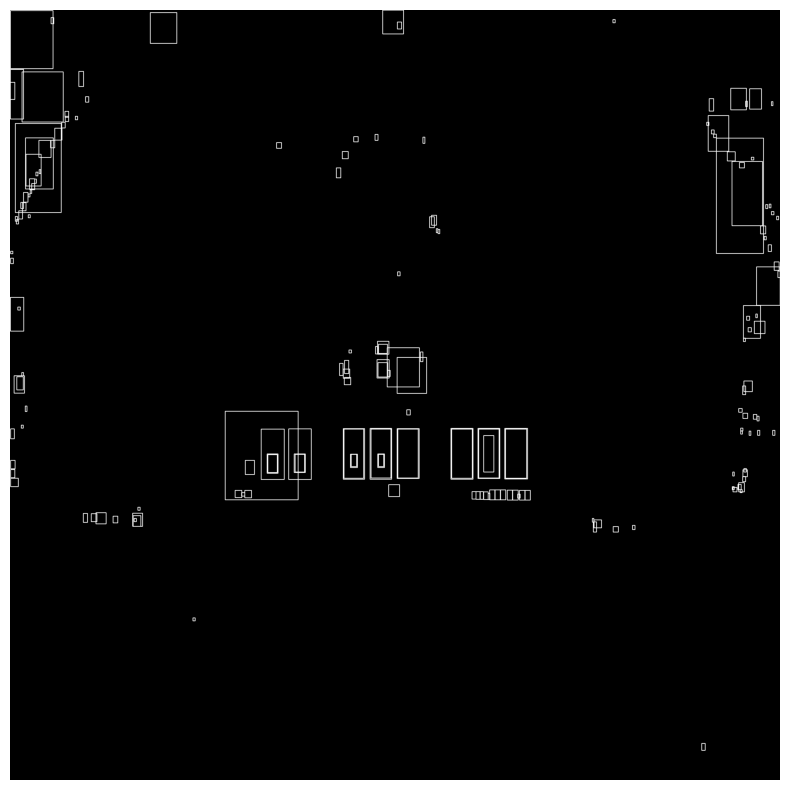

In [11]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.00

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car-Boxes-byCharSize.png',bbox_inches = 'tight')
plt.show()

In [12]:
possible_contours

[{'contour': array([[[2796, 2956]],
  
         [[2796, 2962]],
  
         [[2795, 2963]],
  
         [[2795, 2968]],
  
         [[2794, 2969]],
  
         [[2794, 2970]],
  
         [[2792, 2972]],
  
         [[2788, 2972]],
  
         [[2788, 2981]],
  
         [[2789, 2982]],
  
         [[2790, 2982]],
  
         [[2791, 2983]],
  
         [[2792, 2982]],
  
         [[2793, 2982]],
  
         [[2794, 2981]],
  
         [[2794, 2978]],
  
         [[2795, 2977]],
  
         [[2796, 2977]],
  
         [[2797, 2976]],
  
         [[2798, 2976]],
  
         [[2799, 2975]],
  
         [[2799, 2973]],
  
         [[2800, 2972]],
  
         [[2800, 2971]],
  
         [[2801, 2970]],
  
         [[2801, 2969]],
  
         [[2800, 2968]],
  
         [[2800, 2966]],
  
         [[2801, 2965]],
  
         [[2801, 2963]],
  
         [[2800, 2962]],
  
         [[2800, 2961]],
  
         [[2799, 2960]],
  
         [[2799, 2959]],
  
         [[2797, 2957]],
  
         

## 1.8 Selecting Boxes by Arrangement of Contours

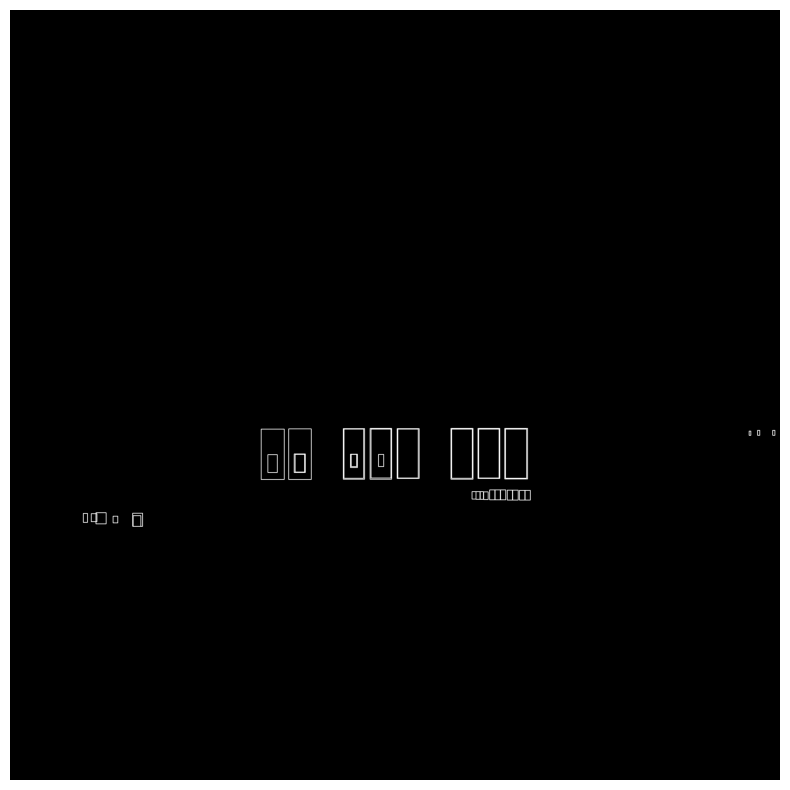

In [13]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car-Boxes-byContourArrangement.png',bbox_inches = 'tight')
plt.show()

## 1.9 Imposing Boxes on Original Image of Car

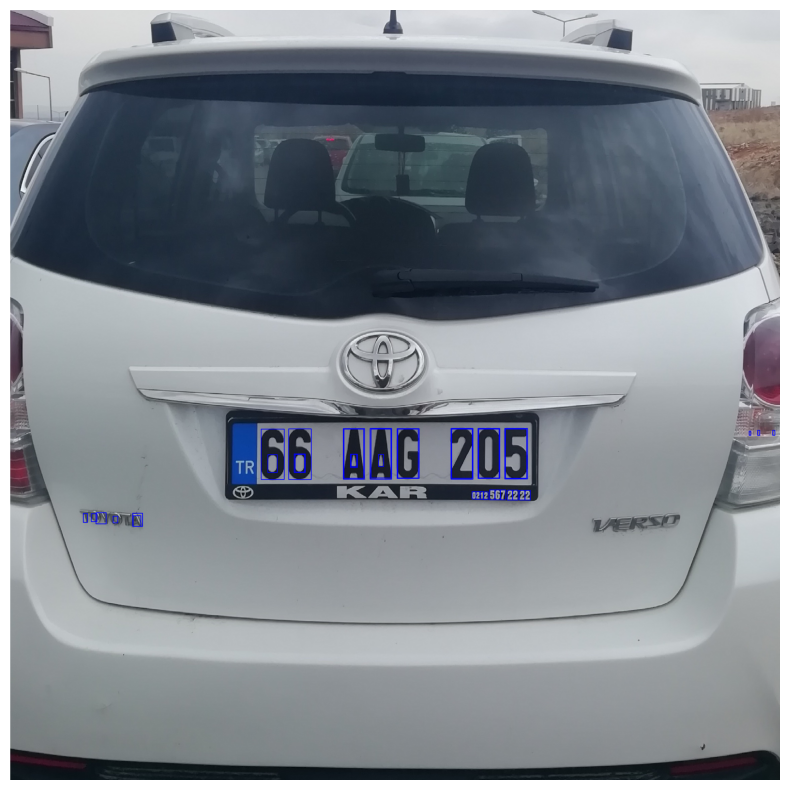

In [18]:
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(im_rgb, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(im_rgb, cmap='gray')
plt.axis('off')
plt.savefig('CarPic\Car-OverlappingBoxes.png',bbox_inches = 'tight')
plt.show()

## 1.10 Rotate Plate Images

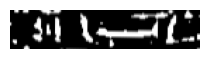

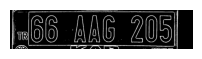

In [23]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 4
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')
    plt.axis('off')
    plt.savefig('CarPic\Car-Plates(Rotated).png',bbox_inches = 'tight')
    plt.show()